In [1]:
import numpy as np
#load data from file导入txt数据
def load_data(filename):
    dataset = []
    label = []
    file = open(filename)
    for line in file.readlines():
        lineArr = line.strip().split('\t')
        dataset.append(lineArr[0:2])
        label.append(lineArr[-1])    
    return np.array(dataset,dtype=np.float64),\
           np.array(label,dtype=np.float64).reshape(-1,1)


(200L, 2L) (200L, 1L)
[ 1.        0.067732] [ 3.176513]


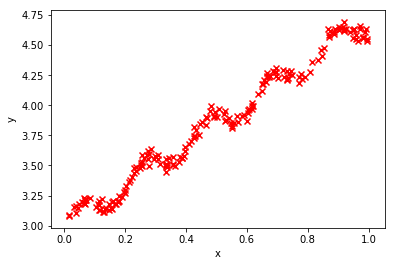

In [2]:
import matplotlib.pyplot as plt
#导入数据并且可视化一下
x,y = load_data("regress/ex0.txt")
print x.shape,y.shape
print x[0],y[0]


plt.scatter(x[:,1],y[:,0],marker='x',color = 'r')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [4]:
#简单的线性回归，使用求导公式就可以求得w的最优值

def normalEquation(X_train,y_train):
    w = np.zeros((X_train.shape[0],1))
    #这里用的伪逆,所以不用判断矩阵的逆存不存在
    w = ((np.linalg.pinv(X_train.T.dot(X_train))).dot(X_train.T)).dot(y_train)
    return w
w = normalEquation(x,y)
print w



[[ 3.00774324]
 [ 1.69532264]]


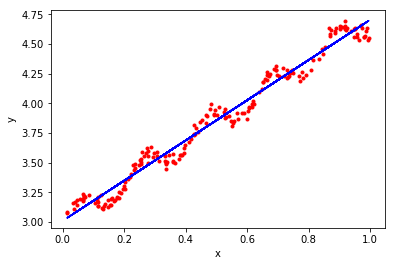

In [5]:
#现在可视化一下求得w的效果
plt.scatter(x[:,1],y[:,0],marker='.',color = 'r')
plt.plot(x[:,1],x.dot(w),color = "blue",linestyle = "-")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [6]:
#使用相关系数函数，评价拟合的好坏,得到两两相关的矩阵
yHat = x.dot(w)
print yHat.shape
print y.shape
print np.corrcoef(yHat.ravel(),y.ravel())

(200L, 1L)
(200L, 1L)
[[ 1.          0.98647356]
 [ 0.98647356  1.        ]]


In [7]:
#线性回归容易欠拟合，所以实现局部加权线性回归————给待预测点附近的每个点赋予一定的权重
#局部加权线性回归：运算复杂,计算量大；因为对每个点的预测都需要用到整个数据集合

#对单个点，用整个数据集合赋权重，求得预测值
def lwlr(testpoint,x,y,k = 1.0):
    m,n = x.shape
    w = np.eye((m)) #对角元素 = 1的对角矩阵
    weight = np.zeros((n,1))
    #求得测试点关于其他的数据点的权重，离得越近，权重越大
    for i in xrange(m):
        d = testpoint - x[i,:]
        w[i,i] = np.exp(d.dot(d.T) / (-2.0*k**2))
    XTWX = x.T.dot(w).dot(x)
    weight = ((np.linalg.pinv(XTWX).dot(x.T)).dot(w)).dot(y)
    return testpoint.dot(weight)
#对整个测试点，进行预测
def lwlrTest(testArr,x,y,k = 1.0):
    m = x.shape[0]
    y_pred = np.zeros((m,1))
    for i in xrange(m):
        y_pred[i] = lwlr(testArr[i],x,y,k)
    return y_pred

#测试一下
print "should be 3.12204471"
print lwlr(x[0],x,y,k=1)
print "should be 3.20175729"
print lwlr(x[0],x,y,k=0.001)

should be 3.12204471
[ 3.12204471]
should be 3.20175729
[ 3.20175729]


In [8]:
y1 = lwlrTest(x,x,y,k = 1)
y2 = lwlrTest(x,x,y,k = 0.01)
y3 = lwlrTest(x,x,y,k = 0.003)

print y1.shape,y2.shape,y3.shape

(200L, 1L) (200L, 1L) (200L, 1L)


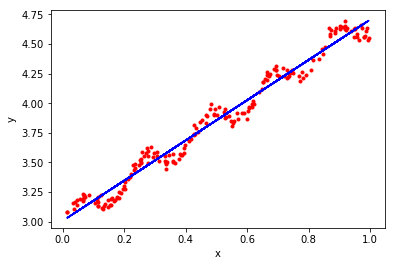

In [9]:
#k = 1，权重很大，就等于将所有的数据视为等权重
plt.scatter(x[:,1],y[:,0],marker='.',color = 'r')
plt.plot(x[:,1],y1.ravel(),color = "blue",linestyle = "-")
plt.xlabel('x')
plt.ylabel('y')
plt.show()


(200L,)
(200L, 2L)


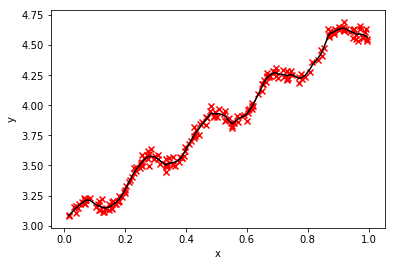

In [12]:
#k=0.01拟合的挺好
#为了绘制曲线图，需要将数据点排序
srtIndex = x[:,1].argsort(0)
print srtIndex.shape
x_sort = x[srtIndex]
print x_sort.shape


plt.scatter(x[:,1],y[:,0],marker='x',color = 'r')
plt.plot(x_sort[:,1],y2[srtIndex],color="black")
#plt.scatter(x[:,1],y2,color = "blue",marker=".") #也可以用散点表示，不用排序
plt.xlabel('x')
plt.ylabel('y')
plt.show()


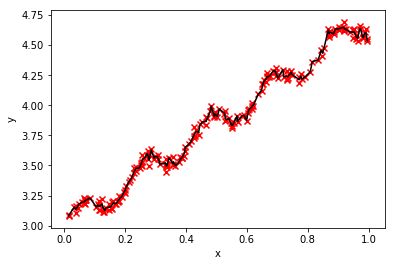

In [13]:
# k = 0.003有点过拟合了
plt.scatter(x[:,1],y[:,0],marker='x',color = 'r')
plt.plot(x_sort[:,1],y3[srtIndex],color="black")
#plt.scatter(x[:,1],y3,color = "blue",marker=".")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [11]:
#当数据的特征非常的多，n>m时，则输入数据X不是满秩矩阵，非满秩矩阵求逆会有问题
#岭回归 == 加入了正则化,缩减权重系数，也就是减少特征值数量

#岭回归公式求解
def ridgeRegress(x,y,lammda = 0.2):
    m,n = x.shape
    I = np.eye((n))
    temp = x.T.dot(x) + lammda * I
    w = np.linalg.pinv(temp).dot(x.T).dot(y)    
    return w


def test(x,y):
    ymean = np.mean(y,axis=0)
    y_nor = y - ymean #对y也进行0均值化
    xmean = np.mean(x,axis=0)  #对x进行0均值化，方差标准化
    xvar = np.var(x,axis=0)
    x_nor = (x - xmean) / xvar
    num = 30
    ws = np.zeros((num,x.shape[1]))
    for i in xrange(num):  #选择30个lamda计算
        w = ridgeRegress(x_nor,y_nor,np.exp(i-10)) #注意这里用的lamda是指数级变化的
        ws[i,:] = w.ravel().T
    return ws



In [12]:
import numpy as np
#load data from file导入txt数据
def load_data1(filename):
    dataset = []
    label = []
    file = open(filename)
    for line in file.readlines():
        lineArr = line.strip().split('\t')
        m = len(lineArr)
        dataset.append(lineArr[0:m-1])
        label.append(lineArr[-1])    
    return np.array(dataset,dtype=np.float64),\
           np.array(label,dtype=np.float64).reshape(-1,1)

In [13]:
xx,yy = load_data1("regress/abalone.txt")
print xx.shape,yy.shape

(4177L, 8L) (4177L, 1L)


In [15]:
ws = test(xx,yy)
print ws.shape 

(30L, 8L)


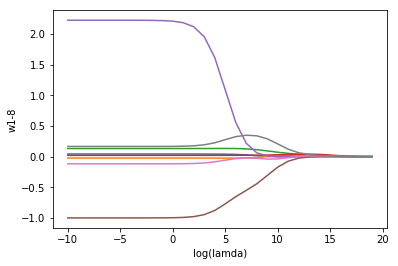

In [16]:
plt.plot([i-10 for i in xrange(30)],ws)
plt.xlabel("log(lamda)")
plt.ylabel("w1-8")
plt.show()
#可以看出，当lamda很小时候，各个权重参数跟普通的回归一样，有各自的值，
#当lamda很大时，权重参数 缩减为0，因为进行了惩罚，让有些参数不起作用
#可以在中间某处找到合适的参数lamda

In [31]:
#向前逐步回归——————贪心算法：从初始值，每次更新（增大一点/减少一点），看看哪个有利于减少误差，就选择哪个更新，

#这是一个0均值化，方差为1的特征归一化过程
def normalFeature(x):
    m,n = x.shape
    mean = np.mean(x,axis=0)
    var = np.var(x,axis=0)
    x_nor = (x - mean) / var
    return x_nor,mean,var

#求平方误差
def rssError(y,yhat):
    return np.sum((y-yhat)**2)

#前向逐步回归
def stageWise(x,y,learn_rate = 0.005,iters = 1000):
    m,n = x.shape
    y_mean = np.mean(y,axis=0)
    y_nor = y - y_mean
    x_nor,x_mean,x_var = normalFeature(x)
    
    ws = np.zeros((iters,n)) #用来记录w的迭代变化
    w = np.zeros((n,1)) #实际的权重w
    w_update = w.copy() #用于w的更新
    w_best = w.copy() #存储最好的w
    
    for i in xrange(iters):
        if (i%100) ==0:
            print w.ravel()
        lowestError = np.inf #最小的误差
        for j in xrange(n): #每次对一个特征（权重系数w0-w8）进行改变，看看误差变化
            for update_size in [-1,1]:
                w_update = w.copy()
                w_update[j] += learn_rate * update_size #更新
                yhat = x_nor.dot(w_update.reshape(-1,1)) 
                error = rssError(y_nor,yhat)
                if error < lowestError:
                    lowestError = error
                    w_best = w_update
        w = w_best.copy()
        ws[i,:] = w.T
    return ws
                
 

In [36]:
ws = stageWise(xx,yy,learn_rate=0.005,iters=1000)
print ws.shape

[ 0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.     0.     0.01   0.045  0.    -0.18   0.     0.225]


[ 0.     0.     0.085  0.03   0.    -0.47   0.     0.345]
[ 0.025  0.     0.1    0.025  0.26  -0.62  -0.005  0.365]


[ 0.035  0.     0.105  0.025  0.615 -0.695 -0.025  0.33 ]
[ 0.04   0.     0.105  0.025  0.98  -0.77  -0.045  0.295]


[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]
[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]


[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]
[ 0.045  0.     0.105  0.025  1.295 -0.83  -0.06   0.26 ]


(1000L, 8L)


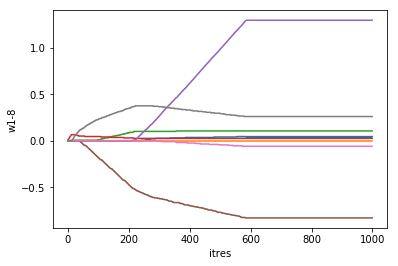

In [37]:
plt.plot(ws)
plt.xlabel("itres")
plt.ylabel("w1-8")
plt.show()


In [38]:
#向前逐步回归，可以从上图看出，那些变化很小的，一直在0附近的权重参数（对应特征），说明他们对误差不产生影响
#这可以帮助我们找出重要的特征

